In [1]:
import pandas as pd
from numpy import array, mean, save
import numpy as np

In [17]:
from tqdm import tqdm

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
font = {'size'   : 12}
plt.rc('font', **font)

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
dt=pd.read_csv('ROCStories/ROCStories__spring2016 - ROCStories_spring2016.csv')
dt.head(3)

,storyid,storytitle,sentence1,sentence2,sentence3,sentence4,sentence5
0,9a51198e-96f1-42c3-b09d-a3e1e067d803,Overweight Kid,Dan's parents were overweight.,Dan was overweight as well.,The doctors told his parents it was unhealthy.,His parents understood and decided to make a c...,They got themselves and Dan on a diet.
1,617e7ada-3878-488d-bd56-40695b91f053,The Bike Accident,Carrie had just learned how to ride a bike.,She didn't have a bike of her own.,Carrie would sneak rides on her sister's bike.,She got nervous on a hill and crashed into a w...,The bike frame bent and Carrie got a deep gash...
2,79b0da1f-e460-4173-ba58-8c9e2553c53a,Beach,Morgan enjoyed long walks on the beach.,She and her boyfriend decided to go for a long...,"After walking for over a mile, something happe...",Morgan decided to propose to her boyfriend.,Her boyfriend was upset he didn't propose to h...


In [5]:
import nltk
from nltk.tokenize import word_tokenize

# Pretrained BERT

In [6]:
from simpletransformers.language_representation import RepresentationModel

In [7]:
model = RepresentationModel(
    "bert", model_name = 'bert-base-uncased',
    use_cuda = False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTextRepresentation: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTextRepresentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTextRepresentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
model.encode_sentences(['beach'], combine_strategy='mean').shape

(1, 768)

In [9]:
s = dt.iloc[1][5]
s

'She got nervous on a hill and crashed into a wall.'

In [26]:
model.encode_sentences([s], combine_strategy='mean')[0].shape

(768,)

In [15]:
len(dt)

45496

In [21]:

N = len(dt)
N=2000
x, y = [], []
for n in tqdm(range(N)):
    for k in range(2,7):
        s = dt.iloc[n][k]        
        vec = model.encode_sentences([s], combine_strategy='mean')[0]
        x.append(vec)
        y.append(k-2)
            
x = array(x)
y = array(y)
        
x.shape, y.shape

100%|██████████| 2000/2000 [05:52<00:00,  5.67it/s]


((10000, 768), (10000,))

In [22]:
save('x-bert.npy', x)
save('y-bert.npy', y)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2024, test_size=0.25)
x_test.shape, y_test.shape

((2500, 768), (2500,))

# BERT + Logistic regression

In [24]:
%%time

m = LogisticRegression()
m.fit(x_train, y_train)
y_predict = m.predict(x_test)

CPU times: user 18.5 s, sys: 2.94 s, total: 21.5 s
Wall time: 1.87 s


/home/surov/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
conmat = confusion_matrix(y_test, y_predict)
print(conmat)

[[364  64  33  20  23]
 [119 149 113  87  58]
 [ 49 119 144 125  54]
 [ 33  98 122 119 112]
 [ 26  30  53 102 284]]


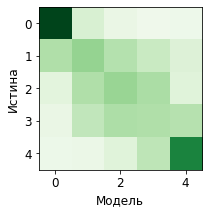

In [26]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

In [27]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.62      0.72      0.66       504
           1       0.32      0.28      0.30       526
           2       0.31      0.29      0.30       491
           3       0.26      0.25      0.25       484
           4       0.53      0.57      0.55       495

    accuracy                           0.42      2500
   macro avg       0.41      0.42      0.42      2500
weighted avg       0.41      0.42      0.42      2500



### Точность примерно как в word2vec, но картинка смотрится лучше

# BERT + K nearest neighbors

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
knn = KNeighborsClassifier(n_neighbors=50, weights='distance')
knn.fit(x_train, y_train)

y_preds_knn = knn.predict(x_test)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f29a0ac8ee0>
Traceback (most recent call last):
  File "/home/surov/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/surov/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/surov/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/surov/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [30]:
conmat = confusion_matrix(y_test, y_preds_knn)
print(conmat)

[[405  33  33  18  15]
 [181  96 102  75  72]
 [110  62 142 102  75]
 [ 69  48 120 125 122]
 [ 80  31  45  71 268]]


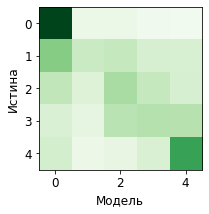

In [31]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

In [32]:
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.48      0.80      0.60       504
           1       0.36      0.18      0.24       526
           2       0.32      0.29      0.30       491
           3       0.32      0.26      0.29       484
           4       0.49      0.54      0.51       495

    accuracy                           0.41      2500
   macro avg       0.39      0.41      0.39      2500
weighted avg       0.39      0.41      0.39      2500



### Здесь без заметной разницы

# BERT + LinearDiscriminantAnalysis + KNN

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [34]:
lda = LinearDiscriminantAnalysis(n_components=3);
lda.fit(x_train, y_train)

LinearDiscriminantAnalysis(n_components=3)

In [35]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(lda.transform(x_train), y_train)

y_preds_knn = knn.predict(lda.transform(x_test))

[[356  75  22  25  26]
 [122 147 114  88  55]
 [ 50 127 147 116  51]
 [ 32 114  91 143 104]
 [ 30  35  48  94 288]]


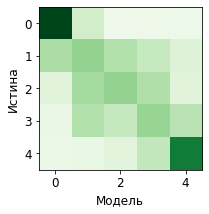

In [36]:
conmat = confusion_matrix(y_test, y_preds_knn)
print(conmat)
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

In [37]:
print(classification_report(y_test, y_preds_knn))

              precision    recall  f1-score   support

           0       0.60      0.71      0.65       504
           1       0.30      0.28      0.29       526
           2       0.35      0.30      0.32       491
           3       0.31      0.30      0.30       484
           4       0.55      0.58      0.57       495

    accuracy                           0.43      2500
   macro avg       0.42      0.43      0.43      2500
weighted avg       0.42      0.43      0.43      2500



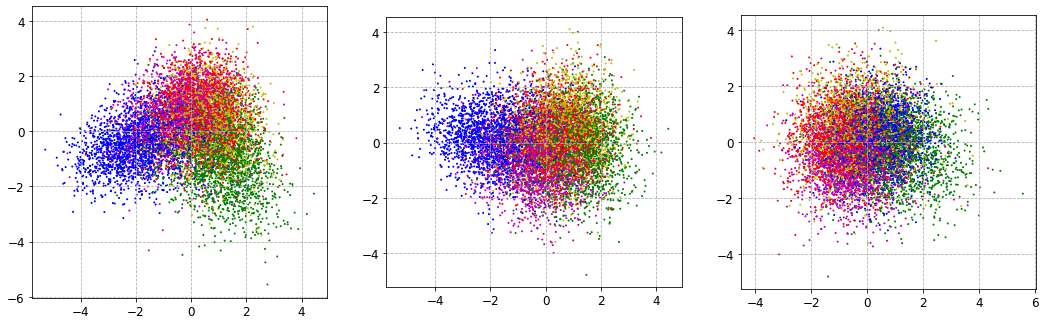

In [38]:
xdim3 = lda.transform(x)
# Окраска классов в порядке столбцов датафрейма.
cmap = mpl.colors.ListedColormap(['b','m','r','y','g'])
norm = mpl.colors.BoundaryNorm([0,1,2,3,4,5], 5)

fig, ax = plt.subplots(1,3,figsize=(18,6))
ax[0].scatter(xdim3[:, 0], -xdim3[:, 1], c=y, s=1, cmap=cmap, norm=norm);
ax[1].scatter(xdim3[:, 0], -xdim3[:, 2], c=y, s=1, cmap=cmap, norm=norm);
ax[2].scatter(xdim3[:, 1], -xdim3[:, 2], c=y, s=1, cmap=cmap, norm=norm);

for a in ax: 
    a.grid(True, ls='--')
    a.set_aspect(1)

### Точность выше на 1%, первая картинка несколько симпатичнее чем на Word2vec

## Из первой картинки видно как три сдерних класса (фиолетовый, красный, жёлтый) сваливаются в кучу. Отсюда возникла идея их объединить и прийти к трёхклассовой классификации. Попробуем:

In [39]:
y

array([0, 1, 2, ..., 2, 3, 4])

In [40]:
def mapf(x):
    if x==0: return 0
    if x==1 or x == 2 or x == 3: return 1
    if x==4: return 2

In [41]:
y2=array(list(map(mapf, y)))
y2

array([0, 1, 1, ..., 1, 1, 2])

In [42]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x, y2, random_state=2024, test_size=0.25)
x2_test.shape, y2_test.shape

((2500, 768), (2500,))

# Logistic Regression

In [43]:
%%time

m = LogisticRegression()
m.fit(x2_train, y2_train)
y2_predict = m.predict(x2_test)

CPU times: user 17.7 s, sys: 2.85 s, total: 20.5 s
Wall time: 1.8 s


/home/surov/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [44]:
conmat = confusion_matrix(y2_test, y2_predict)
conmat

array([[ 321,  172,   11],
       [ 144, 1223,  134],
       [  22,  234,  239]])

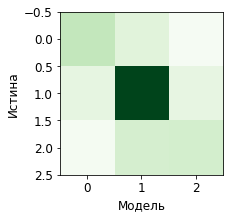

In [45]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

In [46]:
print(classification_report(y2_test, y2_predict))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65       504
           1       0.75      0.81      0.78      1501
           2       0.62      0.48      0.54       495

    accuracy                           0.71      2500
   macro avg       0.68      0.64      0.66      2500
weighted avg       0.71      0.71      0.71      2500



# LDA + KNN

In [47]:
lda = LinearDiscriminantAnalysis(n_components=2);
lda.fit(x2_train, y2_train)

LinearDiscriminantAnalysis(n_components=2)

In [48]:
knn = KNeighborsClassifier(n_neighbors=70)
knn.fit(lda.transform(x2_train), y2_train)

y2_preds_knn = knn.predict(lda.transform(x2_test))

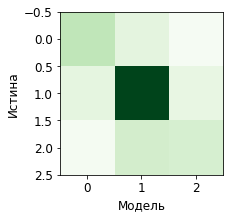

In [51]:
conmat = confusion_matrix(y2_test, y2_preds_knn)
conmat
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

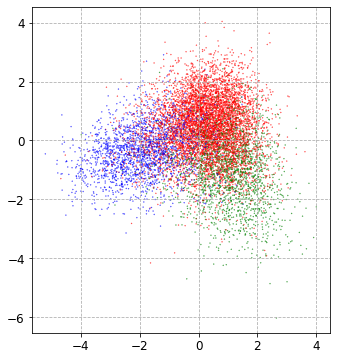

In [49]:
xdim3 = lda.transform(x)

cmap = mpl.colors.ListedColormap(['b','r','g'])
norm = mpl.colors.BoundaryNorm([0,1,2,3], 3)

fig, ax = plt.subplots(1,1,figsize=(18,6))
ax.scatter(xdim3[:, 0], -xdim3[:, 1], c=y2, s=0.1, cmap=cmap, norm=norm);

ax.grid(True, ls='--')
ax.set_aspect(1)

In [50]:
print(classification_report(y2_test, y2_preds_knn))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       504
           1       0.75      0.82      0.78      1501
           2       0.62      0.46      0.52       495

    accuracy                           0.71      2500
   macro avg       0.68      0.64      0.66      2500
weighted avg       0.71      0.71      0.71      2500



In [ ]:
# Точность ожидаемо возросла

## Возможно мешает дисбаланс классов, т.к. объединённый втрое больше остальных. Уравняем:

In [52]:
from numpy import random

In [57]:
random.choice([0,1,2])

1

In [59]:
def mapf(x):
    if x==2: return 0
    if x==3 or x == 4 or x == 5: return 1
    if x==6: return 2

In [60]:
N = len(dt)
x, y = [], []
for n in tqdm(range(2000)):
    
    k3 = random.choice([3,4,5])
    for k in [2,k3,6]:
        
        s = dt.iloc[n][k]        
        vec = model.encode_sentences([s], combine_strategy='mean')[0]
        x.append(vec)
        y.append(mapf(k))
                    
x = array(x)
y = array(y)
        
x.shape, y.shape

100%|██████████| 2000/2000 [03:42<00:00,  9.01it/s]


((6000, 768), (6000,))

In [62]:
save('x3-bert.npy', x)
save('y3-bert.npy', y)

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=2024, test_size=0.25)
x_test.shape, y_test.shape

((1500, 768), (1500,))

# Logistic Regression

In [64]:
m = LogisticRegression()
m.fit(x_train, y_train)
y_predict = m.predict(x_test)

/home/surov/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [65]:
conmat = confusion_matrix(y_test, y_predict)
conmat

array([[399,  73,  38],
       [ 90, 272, 137],
       [ 32, 123, 336]])

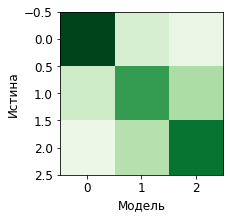

In [66]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

In [67]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.77      0.78      0.77       510
           1       0.58      0.55      0.56       499
           2       0.66      0.68      0.67       491

    accuracy                           0.67      1500
   macro avg       0.67      0.67      0.67      1500
weighted avg       0.67      0.67      0.67      1500



# KNN

In [68]:
knn = KNeighborsClassifier(n_neighbors=50, weights='distance')
knn.fit(x_train, y_train)

y_predict = knn.predict(x_test)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f299a8f5160>
Traceback (most recent call last):
  File "/home/surov/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/surov/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/surov/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/surov/anaconda3/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


In [71]:
conmat = confusion_matrix(y_test, y_predict)
print(conmat)
print(classification_report(y_test, y_predict))

[[438  46  26]
 [175 175 149]
 [ 75  73 343]]
              precision    recall  f1-score   support

           0       0.64      0.86      0.73       510
           1       0.60      0.35      0.44       499
           2       0.66      0.70      0.68       491

    accuracy                           0.64      1500
   macro avg       0.63      0.64      0.62      1500
weighted avg       0.63      0.64      0.62      1500



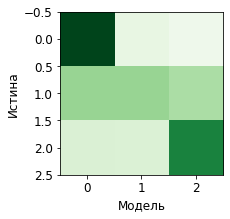

In [72]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

# LDA + KNN

In [73]:
lda = LinearDiscriminantAnalysis(n_components=2);
lda.fit(x_train, y_train)

LinearDiscriminantAnalysis(n_components=2)

In [74]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(lda.transform(x_train), y_train)

y_predict = knn.predict(lda.transform(x_test))

In [75]:
conmat = confusion_matrix(y_test, y_predict)
print(conmat)
print(classification_report(y_test, y_predict))

[[408  68  34]
 [101 260 138]
 [ 39 133 319]]
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       510
           1       0.56      0.52      0.54       499
           2       0.65      0.65      0.65       491

    accuracy                           0.66      1500
   macro avg       0.65      0.66      0.65      1500
weighted avg       0.65      0.66      0.66      1500



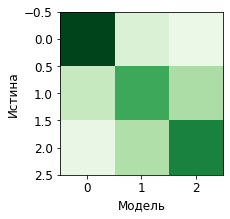

In [76]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.imshow(conmat, cmap='Greens', vmin=0);
ax.set_ylabel('Истина')
ax.set_xlabel('Модель');

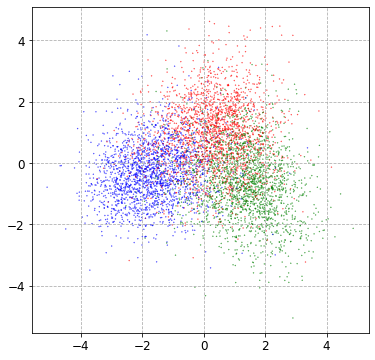

In [77]:
xdim3 = lda.transform(x)

cmap = mpl.colors.ListedColormap(['b','r','g'])
norm = mpl.colors.BoundaryNorm([0,1,2,3], 3)

fig, ax = plt.subplots(1,1,figsize=(18,6))
ax.scatter(xdim3[:, 0], -xdim3[:, 1], c=y, s=0.1, cmap=cmap, norm=norm);

ax.grid(True, ls='--')
ax.set_aspect(1)

## Снова в пониженной размерности KNN увеличивает точность. По сравнению с word2vec BERT везде даёт прирост 1-2%. Лучший результат: Logistic Regression (0.67) и LDA+KNN (0.66)

# BERT + Bayes

In [79]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

ValueError: Negative values in data passed to MultinomialNB (input X)

## Можно ли как-то применять этот метод к отрицательным векторам?